In [96]:
!pip install yfinance pandas  matplotlib openpyxl 


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## EXPLORATORY DATA ANALYSIS on Apple Stock (2022-01-01 to 2024-12-31)

### Questions to Ask About this dataset
1. *Trend Analysis:*
   - What’s the overall price trend of AAPL over this period?
   - Are there distinct bullish or bearish phases?
2. *Volatility:*
   - How volatile is AAPL daily? Are there periods of unusually high or low volatility?
3. *Volume:*
   - How does trading volume correlate with price movements?
   - Are there spikes in volume tied to specific events?
4. *Indicators:*
   - What do RSI and MACD reveal about momentum and overbought/oversold conditions?
   - Are there notable crossovers (e.g., golden/death cross) in moving averages?
5. *Seasonality and Patterns:*
   - Are there recurring patterns (e.g., monthly or quarterly effects)?
   - How does AAPL perform around key dates (e.g., earnings reports)?
6. *Anomalies:*
   - Are there outliers or sudden price/volume shifts that need explanation?
7. *Conclusion:*
   

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from typing import List
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

### Step 1: Data Collection

In [2]:
def retrieve_stock_data(ticker, start_date, end_date):
    """This function retrieves stock data from Yahoo Finance and calculate daily returns
    Parameters:
        ticker (string): stock ticker
        start_date (string): start date
        end_date (string): end date
        """
    # Retrieving and downloading data....
    try:
        # Fetch the stock data
        stock = yf.Ticker(ticker).history(start=start_date, end=end_date)
        
        # Check if data is empty
        if stock.empty:
            raise ValueError(f"No data found for ticker '{ticker}' between {start_date} and {end_date}")
        
        # Resetting indexes in case we have multi-index
        if isinstance(stock.columns, pd.MultiIndex):
            stock.columns = stock.columns.get_level_values(0)
        
        stock['Daily_Return'] = stock['Close'].pct_change() * 100
        stock['Cumulative_Return'] = (1 + stock['Close'].pct_change()).cumprod()
        
        print('Stock data retrieved successfully....')
        print(f'Columns Retrieved are : {stock.columns}')

        return stock
    
    except Exception as e:
        print(f"Error retrieving stock data for {ticker}: {str(e)}")
        return None
    
    
    # Global Variables
TICKER = 'AAPL'
START_DATE = '2022-01-01'
END_DATE = '2024-12-31'

stock = retrieve_stock_data(TICKER, START_DATE, END_DATE)


Stock data retrieved successfully....
Columns Retrieved are : Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Daily_Return', 'Cumulative_Return'],
      dtype='object')


### Step 2: Data Cleaning

In [7]:
def clean_data(data, columns: List, xlsx_file=None):
    """This function cleans stock data retrieved from Yahoo Finance
    Parameters:
        data(DataFrame): stock data retrieved from Yahoo Finance
        columns(list): list of columns needed to work with
        xlsx_file(string): name of the xlsx file to save the data """
    
    print(f"===== Null count ===== \n{data.isnull().sum()}")
    
    cleaned_stock = data[columns]
    if xlsx_file:
        cleaned_stock.to_excel(xlsx_file)
        print(f"Data saved to {xlsx_file}")
    return cleaned_stock

stock = clean_data(stock, ['Open', 'High', 'Low', 'Close', 'Volume','Daily_Return','Cumulative_Return'])

 ===== Null count ===== 
Open                 0
High                 0
Low                  0
Close                0
Volume               0
Daily_Return         1
Cumulative_Return    1
dtype: int64


### Step 3: Indicator Calculation

## Moving Averages in Stock Market Analysis

Moving Averages are a fundamental tool in stock market analysis, used to smooth out stock price data and identify trends. They calculate the average of prices over a specified period (e.g., 10, 20, 30, or 100 days) and update dynamically as new data becomes available.

### Types of Moving Averages

There are two primary types of moving averages:

1. **Simple Moving Average (SMA)**  
   The SMA calculates the average of closing prices over a defined period, such as 50 days, giving equal weight to each day. It is effective for tracking gradual, long-term trends.

2. **Exponential Moving Average (EMA)**  
   The EMA places greater weight on more recent prices, making it more responsive to price changes. This makes it ideal for short-term analysis, as it reacts faster to market movements.

### Interpretation

In datasets, moving averages help reveal momentum and potential trend shifts:

- **Uptrend Signal**: When the stock price crosses above an SMA or EMA, it may indicate the start of an uptrend.
- **Downtrend Signal**: Conversely, when the price drops below an SMA or EMA, it may suggest a downtrend.
- **Key Patterns**:
  - **Golden Cross**: A bullish signal where the 50-day SMA crosses above the 200-day SMA, indicating potential upward momentum.
  - **Death Cross**: A bearish signal where the 50-day SMA crosses below the 200-day SMA, suggesting potential downward momentum.

In the analysis below, we calculate the 50-day SMA, 200-day SMA, and EMA to identify these trends and patterns.

In [8]:
def moving_average_calculation(data, short_window=50, long_window=200):
    """
    Calculate moving average like SMA50, SMA200, EMA50 and Bollinger Band of stock data.
    Parameters:
    - data (DataFrame): Stock data with 'Close' prices.
    - short_window (int): Period for short-term SMA (default: 50).
    - long_window (int): Period for long-term SMA (default: 200).
    
    Returns:
    - DataFrame with added SMA50, SMA200, and EMA50 columns.
    """
    
    # Simple Moving Averages
    data['SMA50'] = data['Close'].rolling(window=short_window).mean()
    data['SMA200'] = data['Close'].rolling(window=long_window).mean()
    
    # Exponential Moving averages
    data['EMA50'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    
    # Bollinger bands
    data['20SMA'] = data['Close'].rolling(window=20).mean() # Middle Band
    data['Upper_BB'] = (data['Close'].rolling(window=20).std()) * 2 + data['20SMA']
    data['Lower_BB'] = data['20SMA'] - (data['Close'].rolling(window=20).std()) * 2
    
    print('Moving Average Calculus completed....')
    
    return data

stock = moving_average_calculation(stock, short_window=50, long_window=200)

Moving Average Calculus completed....


## MACD in Stock Market Analysis

The Moving Average Convergence Divergence (MACD) is a momentum indicator that analyzes the relationship between two Exponential Moving Averages (EMAs) of a stock's price, typically the 12-day EMA and the 26-day EMA. The MACD is calculated using the following components:

- **MACD Line**: 12-day EMA minus 26-day EMA.
- **Signal Line**: 9-day EMA of the MACD Line.
- **Histogram**: MACD Line minus Signal Line.

### Interpretation

In a dataset, the MACD helps identify trends and momentum shifts:

- **Bullish Signal (Potential Buy)**: When the MACD Line crosses above the Signal Line, it indicates potential upward momentum.
- **Bearish Signal (Potential Sell)**: When the MACD Line crosses below the Signal Line, it suggests potential downward momentum.
- **Divergence**: Divergence between the MACD and the stock price can signal potential reversals, such as when the price makes a new high but the MACD does not, indicating weakening momentum.

The MACD is a versatile tool for traders to gauge the strength and direction of a trend, as well as to spot potential entry and exit points.

In [9]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
     """Calculates MACD and Signal Line."""
     
     data["MACD"] = data["Close"].ewm(span=short_window, adjust=False).mean() - data['Close'].ewm(span=long_window, adjust=False).mean()
     data["MACD_Signal"] = data["Close"].ewm(span=signal_window, adjust=False).mean()
     data["MACD_Histogram"] = data["MACD"] - data["MACD_Signal"]
     
     print('MACD Calculus completed....')
     return data

stock = calculate_macd(stock, short_window=12, long_window=26)

MACD Calculus completed....


## RSI in Stock Market Analysis

The Relative Strength Index (RSI) is a momentum indicator that measures the speed and change of price movements, as well as overbought or oversold conditions, on a scale from 0 to 100. By default, it uses a 14-day period and is calculated based on the average gains and losses over that time.

### Key Levels

- **Above 70 (Overbought)**: Indicates that the stock may be overvalued and due for a pullback.
- **Below 30 (Oversold)**: Suggests that the stock may be undervalued and could rebound soon.

### Interpretation

In our dataset, the RSI helps identify extreme conditions and potential reversals:

- **Rising RSI**: Suggests strengthening momentum in the stock price.
- **Falling RSI**: Indicates weakening momentum.
- **Reversals**: Extreme RSI levels (above 70 or below 30) can signal potential price reversals.

While the RSI is a simple and effective tool, it can sometimes produce false signals, especially in strong trending markets. To improve accuracy, it is often used in conjunction with other indicators like the MACD or Moving Averages.

In [10]:
def calculate_rsi(data, window=14):
    """
    Calculates Relative Strength Index (RSI).
    :param data: 
    :param window: 
    :return: 
    """
    delta = data["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    
    rs = gain / loss
    data["RSI_14"] = 100 - (100 / (1 + rs))
    
    print('14-Relative Strength Index Calculus completed....')
    
    return data

stock = calculate_rsi(stock, window=14)

14 - Relative Strength Index Calculus completed....


### Saving data into excel file

In [11]:
# Create a function to show golden & death cross-moment and uptrend + downtrend moments, 
if len(stock.columns) != 0:
    file_path = f'{TICKER}_stock_data.csv'

    if os.path.exists(file_path):
        print(f"File '{file_path}' already exists. Skipping save operation to avoid overwriting.")
    else:
        stock.to_csv(file_path)
        print('Stock Dataframe saved locally...')

stock_data = pd.read_csv(f'{TICKER}_stock_data.csv', parse_dates=['Date'], index_col='Date')

Stock Dataframe saved locally...


### Step 4: Basic Statistics

In [12]:
print('----------------INFO-----------------')
stock_data.info()

----------------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
Index: 752 entries, 2022-01-03 00:00:00-05:00 to 2024-12-30 00:00:00-05:00
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               752 non-null    float64
 1   High               752 non-null    float64
 2   Low                752 non-null    float64
 3   Close              752 non-null    float64
 4   Volume             752 non-null    int64  
 5   Daily_Return       751 non-null    float64
 6   Cumulative_Return  751 non-null    float64
 7   SMA50              703 non-null    float64
 8   SMA200             553 non-null    float64
 9   EMA50              752 non-null    float64
 10  20SMA              733 non-null    float64
 11  Upper_BB           733 non-null    float64
 12  Lower_BB           733 non-null    float64
 13  MACD               752 non-null    float64
 14  MACD_Signal        752 non-null    float64


In [13]:
stock_data.head()

,Open,High,Low,Close,Volume,Daily_Return,Cumulative_Return,SMA50,SMA200,EMA50,20SMA,Upper_BB,Lower_BB,MACD,MACD_Signal,MACD_Histogram,RSI_14
Date,,,,,,,,,,,,,,,,,
2022-01-03 00:00:00-05:00,174.771805,179.734962,174.653874,178.879913,104487900,NaN,NaN,NaN,NaN,178.879913,NaN,NaN,NaN,0.000000,178.879913,-178.879913,NaN
2022-01-04 00:00:00-05:00,179.489285,179.793951,176.039637,176.609665,99310400,-1.269147,0.987309,NaN,NaN,178.790884,NaN,NaN,NaN,-0.181102,178.425864,-178.606966,NaN
2022-01-05 00:00:00-05:00,176.521213,177.071580,171.636682,171.911865,94537600,-2.659990,0.961046,NaN,NaN,178.521119,NaN,NaN,NaN,-0.695681,177.123064,-177.818745,NaN
2022-01-06 00:00:00-05:00,169.730027,172.285320,168.688259,169.042068,96904000,-1.669342,0.945003,NaN,NaN,178.149391,NaN,NaN,NaN,-1.319843,175.506865,-176.826708,NaN
2022-01-07 00:00:00-05:00,169.916756,171.145259,168.088742,169.209137,86709100,0.098832,0.945937,NaN,NaN,177.798793,NaN,NaN,NaN,-1.780490,174.247319,-176.027809,NaN


In [14]:
stock_data.describe()

,Open,High,Low,Close,Volume,Daily_Return,Cumulative_Return,SMA50,SMA200,EMA50,20SMA,Upper_BB,Lower_BB,MACD,MACD_Signal,MACD_Histogram,RSI_14
count,752.000000,752.000000,752.000000,752.000000,7.520000e+02,751.000000,751.000000,703.000000,553.000000,752.000000,733.000000,733.000000,733.000000,752.000000,752.000000,752.000000,739.000000
mean,176.503343,178.376281,174.812720,176.697677,6.812015e+07,0.060132,0.987784,174.734361,171.033338,174.706809,175.811658,185.789798,165.833519,0.586965,176.301984,-175.715018,53.555655
std,29.432338,29.428851,29.453586,29.507680,2.838173e+07,1.707640,0.165067,26.542209,18.958866,25.323150,28.126484,28.433429,28.241821,3.100463,28.661949,27.363941,18.096280
min,124.561732,126.301493,122.742873,123.583099,2.323470e+07,-5.867956,0.690872,137.165778,145.278692,136.052212,129.439013,136.046069,119.027173,-6.517083,127.164070,-247.600698,7.864737
25%,153.498492,155.737580,151.782209,154.033142,4.877432e+07,-0.844310,0.860873,153.434900,151.937858,153.726538,153.535028,165.665028,143.273433,-1.887255,155.162853,-187.588568,39.333970
50%,171.574104,172.942930,170.135302,171.922958,6.224455e+07,0.114007,0.961046,175.010052,172.669414,174.485863,172.346208,180.228970,164.834569,0.370017,171.849778,-173.072385,54.156814
75%,190.285818,191.815166,189.103919,190.404251,8.059140e+07,0.978314,1.064448,185.828760,182.582585,185.407795,188.457519,196.721224,180.655658,2.942479,188.695191,-154.411684,67.627555
max,257.906429,259.814335,257.347047,258.735504,3.186799e+08,8.897467,1.446420,236.958419,212.437766,239.987368,248.994234,260.449258,237.904829,8.925401,253.607112,-131.743648,96.163014


### Step 5: Visualization

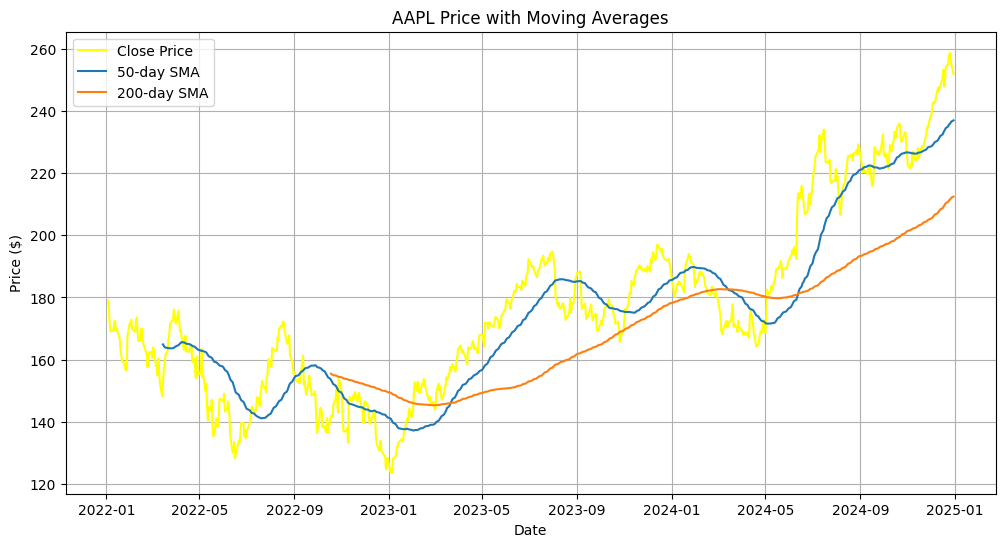

In [59]:
stock_data.index = pd.to_datetime(stock_data.index, utc=True)

# print(f'Index {stock_data.index}')
# Plot Closing Price with SMAs
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['SMA_200'] = stock_data['Close'].rolling(window=200).mean()

plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Close Price', color='yellow')
plt.plot(stock_data.index, stock_data['SMA_50'], label='50-day SMA') # stock_data['Date']
plt.plot(stock_data.index, stock_data['SMA_200'], label='200-day SMA')
plt.title('AAPL Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()
plt.show()

#### AAPL Price with Moving Averages (2022-2024)


 - **Close Price (Yellow):** AAPL stock price fluctuates, peaking around $240 in late 2024, with a low near $130 in early 2023.
 - **50-day SMA (Blue):** Tracks short-term trends, closely following the close price with less volatility.
 - **200-day SMA (Orange):** Shows long-term trend, steadily rising from $150 in 2022 to $200 by 2024, indicating an overall upward trend.
 - **Trend Insight:** Price consistently stays above the 200-day SMA after mid-2023, suggesting a strong bullish trend despite short-term dips.

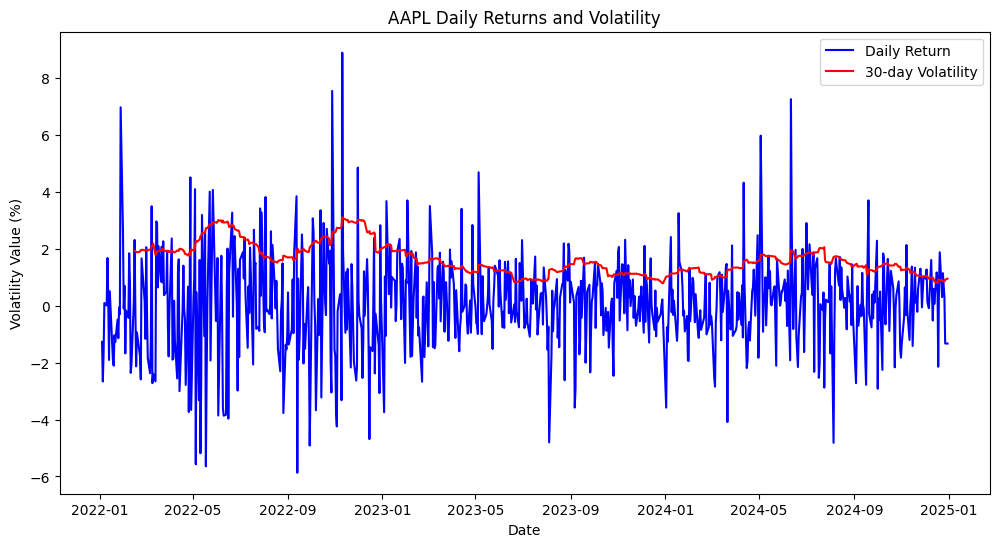

In [65]:
def plot_volatility(data, ticker):
    data["Volatility_30d"] = data["Daily_Return"].rolling(window=30).std()

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Daily_Return'], label='Daily Return', color='blue')
    plt.plot(data.index, data["Volatility_30d"], label="30-day Volatility", color="red")
    plt.title(f"{ticker} Daily Returns and Volatility")
    plt.xlabel("Date")
    plt.ylabel("Volatility Value (%)")
    plt.legend()
    # plt.grid()
    plt.show()
    
plot_volatility(stock_data, TICKER)

### AAPL Daily Returns and Volatility with 30-day Volatility (2022-2024)

- **Daily Return (Blue)**: AAPL daily returns range from -6% to +8%, with significant spikes in early 2022, mid-2022, and late 2024.
- **30-day Volatility (Red)**: Peaks at ~3% in early 2022, dips to ~1% in mid-2023, and rises slightly to ~2% by late 2024.
- **Trend**: Volatility appears to decrease slightly over time, with fewer extreme swings by late 2024.
- **Volatility Insight**: High volatility in 2022 corresponds to large daily return swings; 2023 shows lower volatility, with a slight increase in 2024.

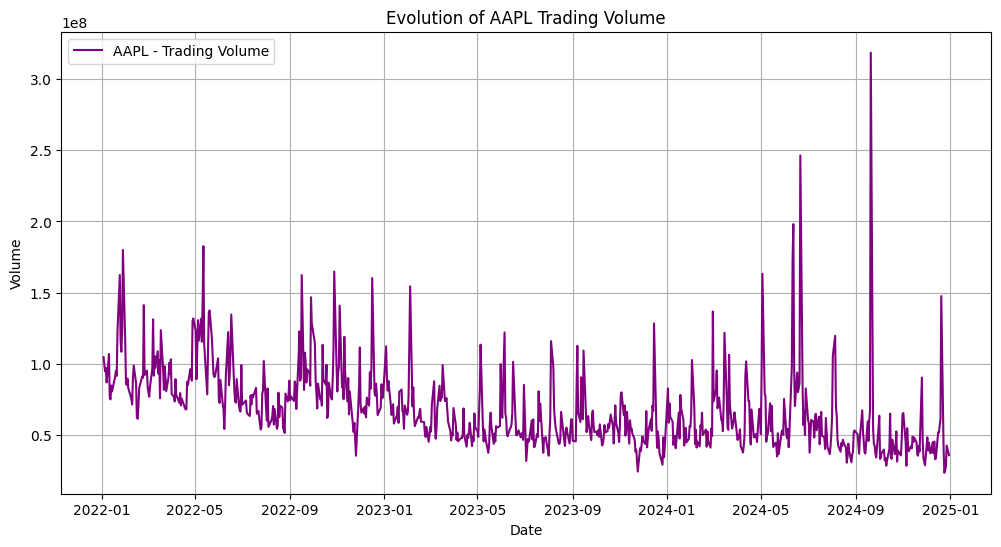

In [68]:
def plot_trading_volume(data, ticker):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data["Volume"], label=f"{ticker} - Trading Volume", color="purple")
    plt.title(f"Evolution of {ticker} Trading Volume")
    plt.xlabel("Date")
    plt.ylabel("Volume")
    plt.legend()
    plt.grid()
    plt.show()
    
plot_trading_volume(stock_data, TICKER)

# AAPL Trading Volume Analysis

## Key Observations:
- **Overall Trend:** Trading volume has been **declining** since early 2022.
- **Volatility:** Volume spikes occur periodically, with **notable peaks in mid-2024**.
- **Liquidity Insight:** Higher volume often aligns with **major market events or earnings reports**.

## Interpretation:
- **High volume → Strong market interest, potential trend changes.**  
- **Low volume → Weak momentum, possible consolidation.**  
- **Sharp spikes → Possible institutional activity or news impact.**

## Conclusion:
Volume analysis should be combined with **price action and indicators** (e.g., RSI, Moving Averages) for **better trading decisions**.


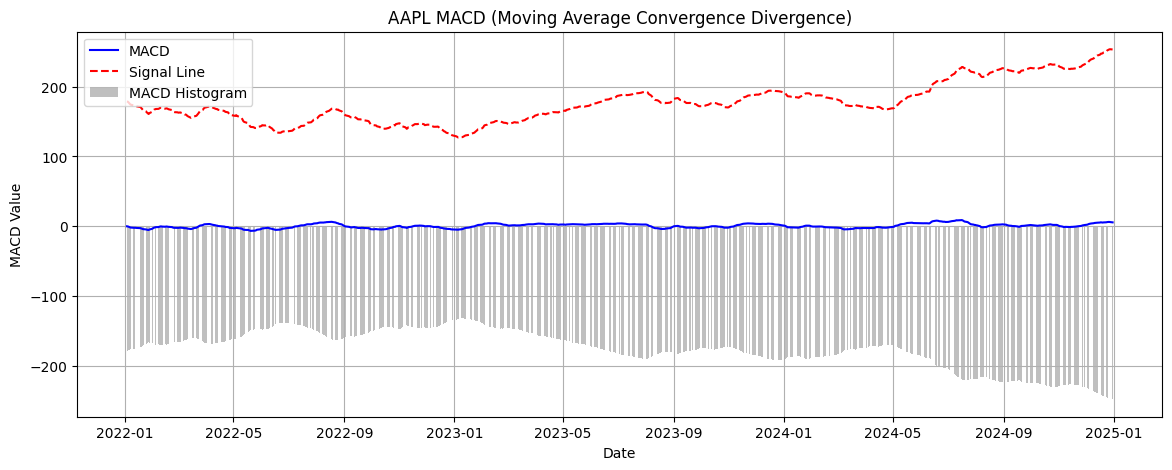

In [32]:

def plot_macd(data, name="Stock"):
    """Plots MACD and Signal Line for trend momentum analysis."""

    plt.figure(figsize=(14, 5))

    plt.plot(data.index, data["MACD"], label="MACD", color="blue")
    plt.plot(data.index, data["MACD_Signal"], label="Signal Line", color="red", linestyle="dashed")
    plt.bar(data.index, data["MACD_Histogram"], color="gray", alpha=0.5, label="MACD Histogram")

    plt.title(f"{name} MACD (Moving Average Convergence Divergence)")
    plt.xlabel("Date")
    plt.ylabel("MACD Value")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_macd(stock_data, TICKER)

# AAPL MACD Analysis

## Key Components:
- **MACD Line (Blue):** Difference between 12-EMA and 26-EMA.
- **Signal Line (Red Dashed):** 9-EMA of the MACD line.
- **Histogram (Gray Bars):** Difference between MACD and Signal line.

## Interpretation:
- **MACD above Signal → Bullish (Buy Signal).**  
- **MACD below Signal → Bearish (Sell Signal).**  
- **Positive Histogram → Uptrend.**  
- **Negative Histogram → Downtrend.**  

## Observations:
- MACD is stable around **0**, indicating weak momentum.  
- Signal line is rising, suggesting a **long-term uptrend**.  
- Histogram shows **strong negative bars**, hinting at a potential correction or consolidation.  


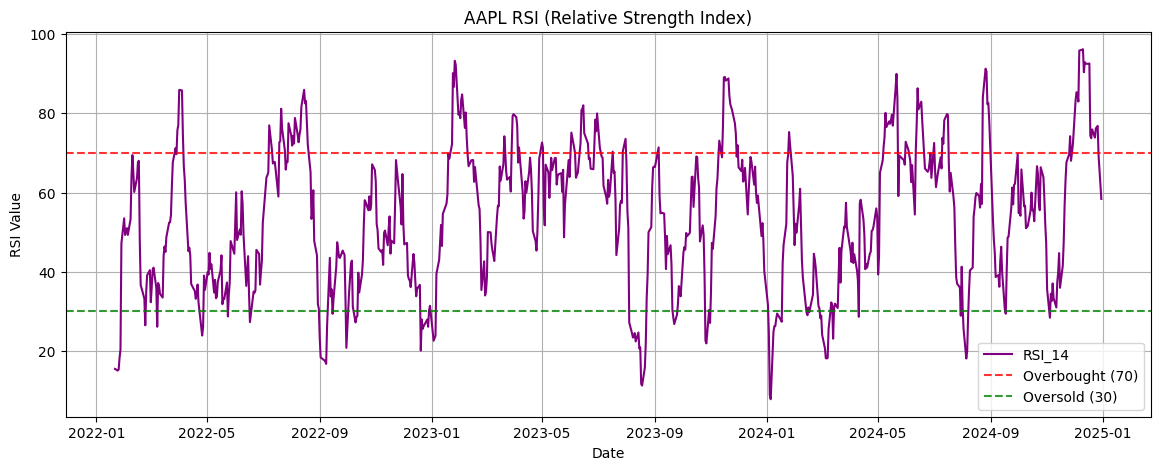

In [34]:
def plot_rsi(data, name="Stock"):
    """Plots RSI with overbought and oversold levels."""

    plt.figure(figsize=(14, 5))

    plt.plot(data.index, data["RSI_14"], label="RSI_14", color="purple")
    plt.axhline(70, color="red", linestyle="dashed", alpha=0.8, label="Overbought (70)")
    plt.axhline(30, color="green", linestyle="dashed", alpha=0.8, label="Oversold (30)")

    plt.title(f"{name} RSI (Relative Strength Index)")
    plt.xlabel("Date")
    plt.ylabel("RSI Value")
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_rsi(stock_data, name=TICKER)

# AAPL RSI Analysis

## Key Components:
- **RSI (Purple Line):** Measures momentum strength.
- **Overbought Level (Red, 70):** Indicates possible overvaluation.
- **Oversold Level (Green, 30):** Indicates possible undervaluation.

## Interpretation:
- **RSI > 70 → Overbought (Potential Sell Signal).**  
- **RSI < 30 → Oversold (Potential Buy Signal).**  
- **RSI between 30-70 → Neutral Zone.**  

## Observations:
- RSI fluctuates frequently between **20 and 80**, showing high volatility.  
- Multiple instances of overbought conditions suggest **possible corrections**.  
- Frequent oversold conditions indicate **buying opportunities**.  

## Conclusion:
The stock shows **strong price swings**.


### Step 6: Trend and Pattern Analysis

In [44]:
# Identify golden/death crosses

stock_data['Golden_Cross'] = (stock_data['SMA_50'] > stock_data['SMA_200']) & (stock_data['SMA_50'].shift(1) <= stock_data['SMA_200'].shift(1))
stock_data['Death_Cross'] = (stock_data['SMA_50'] < stock_data['SMA_200']) & (stock_data['SMA_50'].shift(1) >= stock_data['SMA_200'].shift(1))

print("Golden Cross Dates:\n", stock_data[stock_data['Golden_Cross']].index)
print("Death Cross Dates:\n", stock_data[stock_data['Death_Cross']].index) # [['Date']]


Golden Cross Dates:
 DatetimeIndex(['2023-03-22 04:00:00+00:00', '2024-06-13 04:00:00+00:00'], dtype='datetime64[ns, UTC]', name='Date', freq=None)
Death Cross Dates:
 DatetimeIndex(['2024-03-14 04:00:00+00:00'], dtype='datetime64[ns, UTC]', name='Date', freq=None)


In [47]:
# Monthly average returns
stock_data['Month'] = stock_data.index.to_period('M')
monthly_returns = stock_data.groupby('Month')['Daily_Return'].mean()

monthly_returns_df = pd.DataFrame({
    'Month': monthly_returns.index.astype(str), 
    'Average_Monthly_Return': monthly_returns.values
})

print("Monthly Average Returns DataFrame")
monthly_returns_df


Monthly Average Returns DataFrame


C:\Users\User\AppData\Local\Temp\ipykernel_32712\3592235781.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  stock_data['Month'] = stock_data.index.to_period('M')


,Month,Average_Monthly_Return
0,2022-01,-0.191194
1,2022-02,-0.281316
2,2022-03,0.262228
3,2022-04,-0.487818
4,2022-05,-0.219989
5,2022-06,-0.375333
6,2022-07,0.879175
7,2022-08,-0.125176
8,2022-09,-0.586436
9,2022-10,0.529678


In [46]:
# Volume-Price Correlation
correlation = stock_data['Volume'].corr(stock_data['Close'])

correlation_df = pd.DataFrame({
    'Metric': ['Volume-Price Correlation'],
    'Value': [correlation]
})
print(f"Volume-Price Correlation")
correlation_df

Volume-Price Correlation


,Metric,Value
0,Volume-Price Correlation,-0.406299


### Step 7: Anomaly Detection

In [51]:
# Flag outliers (e.g., returns > 5% or volume > 2x mean)
return_threshold = 0.05
volume_threshold = stock_data['Volume'].mean() * 2
anomalies = stock_data[(abs(stock_data['Daily_Return']) > return_threshold) | (stock_data['Volume'] > volume_threshold)]
print("Anomalies:\n", anomalies[['Close', 'Daily_Return', 'Volume']])

Anomalies:
                                 Close  Daily_Return    Volume
Date                                                         
2022-01-04 05:00:00+00:00  176.609665     -1.269147  99310400
2022-01-05 05:00:00+00:00  171.911865     -2.659990  94537600
2022-01-06 05:00:00+00:00  169.042068     -1.669342  96904000
2022-01-07 05:00:00+00:00  169.209137      0.098832  86709100
2022-01-11 05:00:00+00:00  172.069107      1.678398  76138300
...                               ...           ...       ...
2024-12-23 05:00:00+00:00  254.989655      0.306496  40858800
2024-12-24 05:00:00+00:00  257.916443      1.147807  23234700
2024-12-26 05:00:00+00:00  258.735504      0.317568  27237100
2024-12-27 05:00:00+00:00  255.309296     -1.324213  42355300
2024-12-30 05:00:00+00:00  251.923019     -1.326343  35557500

[732 rows x 3 columns]


### Step 8: Market Moment Classification

In [57]:
# Classify market moments
def classify_moment(row):
    if pd.isna(row['RSI_14']) or pd.isna(row['MACD']):
        return 'N/A'
    elif row['RSI_14'] > 70:
        return 'Overbought'
    elif row['RSI_14'] < 30:
        return 'Oversold'
    elif row['MACD'] > row['MACD_Signal'] and row['RSI_14'] > 50:
        return 'Bullish'
    elif row['MACD'] < row['MACD_Signal'] and row['RSI_14'] < 50:
        return 'Bearish'
    else:
        return 'Neutral'

stock_data['Market_Moment'] = stock_data.apply(classify_moment, axis=1)
print(stock_data['Market_Moment'].value_counts())

Market_Moment
Neutral       284
Bearish       238
Overbought    136
Oversold       81
N/A            13
Name: count, dtype: int64


In [69]:
# Which day has the highest and lowest close price and volume exchanged

stock_data.index = pd.to_datetime(stock_data.index, utc=True)

# Extract month and year as columns
stock_data['Year'] = stock_data.index.year
stock_data['Month'] = stock_data.index.month
stock_data['Month'] = stock_data.index.strftime('%B')

# stock_data.head()

# Group by month and year
pivot_month_year = stock_data.pivot_table(
    index=['Year', 'Month'], 
    values=['Close', 'Volume'], 
    aggfunc={'Close': ['min','max'], 'Volume': ['min','max']}
)

# Renaming columns
pivot_month_year.columns = ['Max_Close','Min_Close', 'Max_Volume', 'Min_Volume']

pivot_month_year.reset_index()

# [pivot_month_year['Year'] == 2022]
pivot_month_2022 = pivot_month_year.loc[2022]
pivot_month_2023 = pivot_month_year.loc[2023]
pivot_month_2024 = pivot_month_year.loc[2024]

# Sort them by month ascendingly
pivot_month_2022 = pivot_month_2022.sort_values(by=['Month'], ascending=True)
pivot_month_2023 = pivot_month_2023.sort_values(by=['Month'], ascending=True)
pivot_month_2024 = pivot_month_2024.sort_values(by=['Month'], ascending=True)

In [70]:
print('** Monthly Analysis of 2022**')
pivot_month_2022

** Monthly Analysis of 2022**


,Max_Close,Min_Close,Max_Volume,Min_Volume
Month,,,,
April,175.594727,154.073471,131747600,67723800
August,172.258087,155.155655,87991100,51218200
December,146.605453,124.591385,160156900,62128300
February,173.469208,157.517654,141147500,61177400
January,178.879913,156.481827,179935700,74805200
July,160.153717,136.915573,101786900,53623900
June,149.017563,128.174179,134520300,53950200
March,176.106461,148.218307,131148300,75615400
May,163.372803,135.358536,182602000,78336300


#### Interpretation of close price over 2022
* Highest Max_Close: April, with a maximum closing price of 175,94.
* Lowest Max_Close: December, with a maximum closing price of 146,60.
* Highest Min_Close: April, with a minimum closing price of 154,07.
* Lowest Min_Close: December, with a minimum closing price of 124,59.
* Observation: The stock price appears to have peaked in April (highest Max_Close and Min_Close) and hit its lowest point in December (lowest Max_Close and Min_Close). This suggests a general downward trend in the stock price over the 2022 year, with a significant decline by the end of the year.

In [71]:
print('** Monthly Analysis of 2023**')
pivot_month_2023

** Monthly Analysis of 2023**


,Max_Close,Min_Close,Max_Volume,Min_Volume
Month,,,,
April,167.985901,158.501572,68445600,41516200
August,193.924881,172.733994,115799700,35175100
December,196.927673,188.299469,128256700,28919300
February,153.779175,143.758514,154357300,44998500
January,144.252777,123.583099,112117500,54105100
July,194.757645,186.459763,80507300,31458200
June,192.298996,176.288147,121946500,46347300
March,163.253616,143.859222,98944600,45992200
May,175.772614,164.134720,113316400,37266700


#### Interpretation of close price over 2023
* Highest Max_Close: March, with a maximum closing price of 197,98.
* Lowest Max_Close: December, with a maximum closing price of 152,77.
* Highest Min_Close: November, with a minimum closing price of 172,70.
* Lowest Min_Close: December, with a minimum closing price of 143,75.
* Observation: The stock price peaked in March (highest Max_Close) and had its highest Min_Close in November, indicating some strong performance mid-to-late in the year. However, it dropped significantly by December (lowest Max_Close and Min_Close), suggesting a decline towards the end of the year, similar to 2022.

In [72]:
print('** Monthly Analysis of 2024**')
pivot_month_2024

** Monthly Analysis of 2024**


,Max_Close,Min_Close,Max_Volume,Min_Volume
Month,,,,
April,175.720276,164.224548,101593300,37425500
August,229.285370,206.535858,119548600,30299000
December,258.735504,239.326859,147495300,23234700
February,188.279587,179.900543,136682600,40867400
January,194.015137,180.098694,82488700,40444700
July,234.033432,216.023956,66034600,36311800
June,215.944229,192.473114,246421400,41181800
March,178.815659,168.205750,121664700,52488700
May,191.705704,168.504349,163224100,34648500


#### Observations:
* December has the highest Max_Close (~= 258.74).
* November has the highest Min_Close (~= 221.52), suggesting relatively stable prices.
* June has the highest Max_Volume (≈ 246M), indicating significant trading activity.
* July has a relatively high Max_Close (≈ 234.03) but a lower Max_Volume (~= 66M), suggesting a price increase with lower trading activity.

In [73]:
def find_best_and_worst_month_per_year(df, year):
    # print(f'Columns {df.columns}')
    # Ensure 'Month' is a column, not the index
    if 'Month' not in df.columns and 'Month' in df.index.name:
        df = df.reset_index()
    
    # If the column is named 'Month_Name' instead of 'Month', adjust accordingly
    month_col = 'Month' if 'Month' in df.columns else 'Month_Name' if 'Month_Name' in df.columns else None
    if month_col is None:
        raise KeyError("Neither 'Month' nor 'Month_Name' found in DataFrame columns")
    # Best month: Highest Max_Close
    best_month = df.loc[df['Max_Close'].idxmax()]
    best_month_name = best_month['Month']
    best_max_close = best_month['Max_Close']
    
    # Best month: Highest Max_Close
    worst_month = df.loc[df['Min_Close'].idxmin()]
    worst_month_name = worst_month['Month']
    worst_min_close = worst_month['Max_Close']
    
    return {
        'year': year,
        'Best Month': best_month_name,
        'Max Close (Best)': best_max_close,
        'Worst Month': worst_month_name,
        'Min Close (Worst)': worst_min_close
    }

result_of_2022 = find_best_and_worst_month_per_year(pivot_month_2023, 2022)
result_of_2023 = find_best_and_worst_month_per_year(pivot_month_2023, 2023)
result_of_2024 = find_best_and_worst_month_per_year(pivot_month_2024, 2024)

results = pd.DataFrame([result_of_2022, result_of_2023, result_of_2024])
results

,year,Best Month,Max Close (Best),Worst Month,Min Close (Worst)
0,2022,December,196.927673,January,144.252777
1,2023,December,196.927673,January,144.252777
2,2024,December,258.735504,April,175.720276


2022: Best month is April (highest Max_Close: 175.94772), worst is December (lowest Min_Close: 124.591385).
2023: Best month is March (highest Max_Close: 197.985886), worst is December (lowest Min_Close: 143.758469).
2024: Best month is August (highest Max_Close: 229.285370), worst is April (lowest Min_Close: 164.224564).

In [74]:
def one_year_return(data):
    # Ensure the index is a DatetimeIndex
    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex")

    end_date = data.index[-1]
    # Calculate the start date (one year before the end date)
    start_date = end_date - pd.Timedelta(days=365)

    # Filter data to get the price on or just after the start date
    start_data = data[data.index >= start_date]
    if start_data.empty:
        print("Not enough data for calculation: No data available one year before the last date.")
        return None
    
    start_price = start_data["Close"].iloc[0]  
    end_price = data["Close"].iloc[-1] 

    # Calculate the return
    return_percent = ((end_price - start_price) / start_price) * 100
    print(f"Return of Stock market year (252 days) starting from {start_data.index[0].date()} to {end_date.date()} is: {return_percent:.2f}%")
    # return return_percent
    
stock_data_2022 = stock_data[stock_data['Year'] == 2022]
stock_data_2023 = stock_data[stock_data['Year'] == 2023]
stock_data_2024 = stock_data[stock_data['Year'] == 2024]

one_year_return(stock_data_2022)

one_year_return(stock_data_2023)

one_year_return(stock_data_2024)

Return of Stock market year (252 days) starting from 2022-01-03 to 2022-12-30 is: -28.20%
Return of Stock market year (252 days) starting from 2023-01-03 to 2023-12-29 is: 54.80%
Return of Stock market year (252 days) starting from 2024-01-02 to 2024-12-30 is: 36.52%


### Step 9: Reporting Insights

In [58]:
# Summary insights
print("Key Insights:")
print(f"- Average Close Price: ${stock_data['Close'].mean():.2f}")
print(f"- Max Volatility: {stock_data['Volatility'].max():.4f}")
print(f"- Most Common Market Moment: {stock_data['Market_Moment'].mode()[0]}")
print(f"- Number of Anomalous Days: {len(anomalies)}")

Key Insights:
- Average Close Price: $176.70
- Max Volatility: 3.1193
- Most Common Market Moment: Neutral
- Number of Anomalous Days: 732


2022: Best month is April (highest Max_Close: 175.94772), worst is December (lowest Min_Close: 124.591385).
2023: Best month is March (highest Max_Close: 197.985886), worst is December (lowest Min_Close: 143.758469).
2024: Best month is August (highest Max_Close: 229.285370), worst is April (lowest Min_Close: 164.224564).

# **Conclusion of Apple Stock Market EDA**  

## **1. Performance Overview**  
- **2022:** A bearish year with a **-28.20%** return, reflecting a downtrend with multiple negative monthly returns (e.g., **-48.78% in April, -58.64% in September**).  
- **2023:** Strong recovery with a **+54.80%** return, supported by a **Golden Cross (March 22, 2023)** indicating a bullish reversal.  
- **2024:** A continued uptrend with a **+36.52% Increase since january to december**, despite a **Death Cross (March 14, 2024)** which typically signals a downtrend. However, another **Golden Cross (June 13, 2024)** suggests a rebound.  

## **2. Volume & Market Sentiment**  
- **Volume-Price Correlation:** **-0.406** (negative correlation), meaning that higher trading volumes generally occur when prices decline, possibly due to panic selling.  
- **Market Classification:**  
  - **Neutral:** **Most common market moment**, indicating sideways movement for extended periods.  
  - **Bearish:** Significant presence (**238 days**), aligning with the downtrend phases in 2022 and early 2024.  
  - **Overbought (136) & Oversold (81):** Suggests frequent market corrections and potential swing trading opportunities.  

## **3. Trading Strategy Considerations**  
- **Golden Crosses (Mar 2023, Jun 2024):** Strong buy signals—investors benefited from the 2023 rally and might expect continued growth in late 2024.  
- **Death Cross (Mar 2024):** Temporary correction before the market resumed its uptrend.  
- **Volatility:** **Max volatility of 3.12** suggests significant price swings, ideal for active traders but risky for passive investors.  

## **4. Key Takeaways**  
 - **2022 was a bearish year, but 2023 marked a strong comeback.**  
 - **2024 started with a dip (Death Cross) but recovered with a Golden Cross in June.**  
 - **Volume trends indicate panic selling and buying spikes, aligning with key events.**  
 - **Market is mostly neutral, meaning strong trends are not always sustained.**  

## **Final Thoughts**  
Apple’s stock has shown strong **bullish momentum since 2023**, with **Golden Crosses confirming uptrends**. However, **volatility remains high**, and **volume analysis suggests emotional trading behaviors**. Investors should watch for trend confirmations and avoid overreacting to short-term fluctuations.
